# Figure 7: Contrail lifetimes

This code will process the `contrail_labels` into contrail width evolutions and lifetimes, which are saved to `data/contrail_evolution/annotations`. Note, you do need the full dataset downloaded to access the IAGOS flight information. The example necessary to reproduce figure 3 is already processed and saved. 

In [1]:
import json
import os
from typing import Union

import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import pyproj
from shapely.geometry import LineString, MultiLineString, shape
from shapely.ops import transform
from sklearn.linear_model import LinearRegression

from pycontrails.datalib import sentinel
from pycontrails.models.sac import T_critical_sac, T_sat_liquid_high_accuracy
from pycontrails.physics.thermo import e_sat_ice, sonntag_e_sat_liquid

from iagos_toolkit.weather.thermo import get_mixing_line_gradient_from_LHV
from iagos_toolkit.flight.aircraft_performance import create_flight_from_iagos

In [2]:
DATASET_LOCATION = "/Volumes/staff-umbrella/IagosSentinelColocations/data/collocations"  # necessary for downloading flight trajectories

df = pd.read_csv('../../data/landsat_sentinel_collocations_20260216.csv', comment='#')

In [3]:
df = df[df["air_temperature_iagos_validity"] <= 0]
df = df[df["rhl_iagos_validity"] <= 0]
df = df[df["contrail_formation"].notna()]
df = df[df["efficiency_PS_IAGOS"].notna()]

df = df[df["satellite"] == "Sentinel"]
df = df[df["contrail_formation"] == True]
df = df[df["contrail_label"].notna()]

print("Number of annotated cases in Sentinel-2:", len(df))

Number of annotated cases in Sentinel-2: 195


## Calculate T_SAC properties for later 

In [4]:
def get_T_SAC(p: Union[float, np.ndarray],
              T: Union[float, np.ndarray],
              RH: Union[float, np.ndarray],
              **kwargs) -> np.ndarray:
    """
    Vectorized computation of T_SAC for given pressure, temperature, and RH.

    Parameters
    ----------
    p : float or np.ndarray
        Pressure in Pa
    T : float or np.ndarray
        Temperature in K
    RH : float or np.ndarray
        Relative humidity w.r.t water [0, 1]
    **kwargs :
        Additional parameters (e.g., eta)
    """
    # Ensure array form
    p = np.atleast_1d(p)
    T = np.atleast_1d(T)
    RH = np.atleast_1d(RH)

    # Broadcast arrays to same shape
    p, T, RH = np.broadcast_arrays(p, T, RH)

    # Vectorized computations
    G = get_mixing_line_gradient_from_LHV(p, **kwargs)
    T_LM = T_sat_liquid_high_accuracy(G)

    # Call T_critical_sac vectorized
    T_SAC = T_critical_sac(T_LM, RH, G, maxiter=10)

    return T_SAC

df["T_SAC_BADA4_IAGOS"] = get_T_SAC(
    df["air_pressure"].values,
    df["air_temperature_iagos"].values,
    df["rhl_iagos"].values,
    eta=df["efficiency_BADA4_IAGOS"].values
)

df["T_SAC_PS_IAGOS"] = get_T_SAC(
    df["air_pressure"].values,
    df["air_temperature_iagos"].values,
    df["rhl_iagos"].values,
    eta=df["efficiency_PS_IAGOS"].values
)

df["T_SAC_BADA4_ERA5"] = get_T_SAC(
    df["air_pressure"].values,
    df["air_temperature_era5"].values,
    df["rhl_era5"].values,
    eta=df["efficiency_BADA4_ERA5"].values
)

df["T_SAC_PS_ERA5"] = get_T_SAC(
    df["air_pressure"].values,
    df["air_temperature_era5"].values,
    df["rhl_era5"].values,
    eta=df["efficiency_PS_ERA5"].values
)

# For IAGOS
df["SAC_BADA4_IAGOS"] = df["air_temperature_iagos"] < df["T_SAC_BADA4_IAGOS"]
df["SAC_PS_IAGOS"]    = df["air_temperature_iagos"] < df["T_SAC_PS_IAGOS"]

# For ERA5
df["SAC_BADA4_ERA5"]  = df["air_temperature_era5"] < df["T_SAC_BADA4_ERA5"]
df["SAC_PS_ERA5"]     = df["air_temperature_era5"] < df["T_SAC_PS_ERA5"]

df["delta_T_SAC_PS_IAGOS"] = df["air_temperature_iagos"] - df["T_SAC_PS_IAGOS"]
df["delta_T_SAC_BADA4_IAGOS"] = df["air_temperature_iagos"] - df["T_SAC_BADA4_IAGOS"]
df["delta_T_SAC_PS_ERA5"] = df["air_temperature_era5"] - df["T_SAC_PS_ERA5"]
df["delta_T_SAC_BADA4_ERA5"] = df["air_temperature_era5"] - df["T_SAC_BADA4_ERA5"]

## Helper functions

In [5]:
def polygon_width_at_angle(
    geom, x, y, angle_deg, length=10_000, min_width=20, tol_shortside=50
):
    """
    Computes the width of a (multi)polygon along a given angle through a point,
    ignoring intersections that occur near the short ends (caps) of its minimum rectangles.

    Parameters
    ----------
    geom : shapely Polygon or MultiPolygon
        Polygon geometry in projected units (e.g., meters).
    x, y : float
        Coordinates of the point (outside or near the polygon).
    angle_deg : float
        Angle in degrees (0 = east, 90 = north).
    length : float
        Half-length of the cross line (total line length = 2*length).
    min_width : float
        Minimum intersection width to be considered valid.
    tol_shortside : float
        Distance threshold (in same units) from short edges to treat as "too close."

    Returns
    -------
    width : float or np.nan
        Width of intersection (same units as geom) or np.nan if invalid/near edge.
    """
    angle_rad = np.deg2rad(angle_deg)
    dx = np.cos(angle_rad) * length
    dy = np.sin(angle_rad) * length

    # Create line through (x, y)
    line = LineString([(x - dx, y - dy), (x + dx, y + dy)])

    inter = geom.intersection(line)
    if inter.is_empty:
        return np.nan

    # Collect intersection segments
    if inter.geom_type == "LineString":
        segments = [inter]
    elif inter.geom_type == "MultiLineString":
        segments = list(inter.geoms)
    else:
        return np.nan
    if not segments:
        return np.nan

    # Collect short sides for each polygon
    short_edges_all = []
    polys = geom.geoms if geom.geom_type == "MultiPolygon" else [geom]
    for poly in polys:
        mrr = poly.minimum_rotated_rectangle
        coords = list(mrr.exterior.coords)[:-1]
        edges = [LineString([coords[i], coords[(i + 1) % 4]]) for i in range(4)]
        lengths = [e.length for e in edges]
        short_len = min(lengths)
        # store edges that are approximately the short ones
        for i, L in enumerate(lengths):
            if np.isclose(L, short_len, rtol=0.01):
                short_edges_all.append(edges[i])

    # Evaluate intersections
    valid_widths = []
    for seg in segments:
        if seg.length < min_width:
            continue

        midpoint = seg.interpolate(0.5, normalized=True)
        # distance to all short edges across all polygons
        if not short_edges_all:
            continue
        min_dist = min(midpoint.distance(edge) for edge in short_edges_all)

        if min_dist < tol_shortside:
            continue  # near short side → discard
        valid_widths.append(seg.length)

    return max(valid_widths) if valid_widths else np.nan

def generate_points_along_line(line, step):
    points = []

    if isinstance(line, LineString):
        distances = np.arange(0, line.length + step, step)
        for d in distances:
            pt = line.interpolate(d)
            points.append([pt.x, pt.y])

    elif isinstance(line, MultiLineString):
        for segment in line.geoms:
            distances = np.arange(0, segment.length + step, step)
            for d in distances:
                pt = segment.interpolate(d)
                points.append([pt.x, pt.y])

    return points

def get_width_along_centerline(polygons, x_ac, y_ac, step_size=100):
    results = []
    for polygon in polygons:
        # 1. Minimum rotated rectangle
        mrr = polygon.minimum_rotated_rectangle
        coords = list(mrr.exterior.coords)[:4]  # 4 rectangle corners

        # 2. Find longest rectangle edge
        edges = [
            (coords[i], coords[(i + 1) % 4])
            for i in range(4)
        ]

        edge_lengths = [
            LineString(edge).length for edge in edges
        ]

        longest_edge = edges[np.argmax(edge_lengths)]
        p0, p1 = np.array(longest_edge[0]), np.array(longest_edge[1])

        # Direction vector (unit)
        direction = p1 - p0
        direction = direction / np.linalg.norm(direction)

        # 3. Build centerline through rectangle centroid
        centroid = np.array(mrr.centroid.coords[0])

        # Extend line well beyond polygon bounds
        minx, miny, maxx, maxy = polygon.bounds
        extent = max(maxx - minx, maxy - miny)

        centerline = LineString([
            centroid - direction * extent,
            centroid + direction * extent
        ])

        # Clip centerline to polygon
        centerline = centerline.intersection(mrr)
        if centerline.is_empty:
            continue

        # 4. Generate points along the centerline
        points = generate_points_along_line(centerline, step_size)

        # 5. Compute width at each point (crossline = centerline angle + 90°)
        centerline_angle = np.degrees(np.arctan2(direction[1], direction[0]))
        cross_angle = centerline_angle + 90.0

        for x, y in points:
            width = polygon_width_at_angle(
                geom=polygon,
                x=x,
                y=y,
                angle_deg=cross_angle,
                tol_shortside=250
            )

            # Euclidean distances
            distance = np.sqrt(
                (x - x_ac)**2 +
                (y - y_ac)**2
            )
            results.append((x, y, width, distance))

    # after building your results list of tuples (x, y, width, distance)
    results = np.array(results)  # shape = (n_points, 4)

    # unpack columns
    xs, ys, widths, distances = results[:, 0], results[:, 1], results[:, 2], results[:, 3]

    return xs, ys, widths, distances


In [6]:
def make_json_serializable(obj):
    if isinstance(obj, np.ndarray):
        return [make_json_serializable(x) for x in obj.tolist()]
    
    elif isinstance(obj, (np.floating, float)):
        if np.isnan(obj) or np.isinf(obj):
            return None
        return float(obj)
    
    elif isinstance(obj, (np.integer, int)):
        return int(obj)
    
    elif isinstance(obj, list):
        return [make_json_serializable(x) for x in obj]
    
    elif isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    
    else:
        return obj

## Compute width evolution and save to data/contrail_evolution/annotations

In [8]:
output_dir = "../../data/contrail_evolution/annotations"
os.makedirs(output_dir, exist_ok=True)

contrails = {}

for idx, row in tqdm(df.iterrows(), "Computing contrail widths", total=len(df)):

    # print(f"Processing index {idx}, path {row['path']}")

    intersect_directory = f"{DATASET_LOCATION}/{row['path']}"

    with open(f"{intersect_directory}/metadata.json") as f:
        metadata = json.load(f)

    x_ac = row["x"]
    y_ac = row["y"]
    velocity_ac = row["ground_speed_AC"]

    flight = create_flight_from_iagos(
        f"{intersect_directory}/{metadata['iagos_data']['filename']}", "A333"
    )
    
    target_time = pd.to_datetime(metadata["satellite_data"]["sensing_time"]).round("1s").tz_localize(None)

    handler = sentinel.Sentinel(metadata["satellite_data"]["base_url"], metadata["satellite_data"]["granule_id"], bands=["B02", "B03", "B04"])

    # Project from WGS84 to the x and y coordinates in the UTM coordinate system
    utm_crs = handler.get_crs()
    transformer = pyproj.Transformer.from_crs("EPSG:4326", utm_crs, always_xy=True)

    # # Read contrail label from metadata
    geojson_poly = json.loads(row["contrail_label"])

    # Convert GeoJSON to a Shapely geometry]
    geom = shape(geojson_poly)

    # Transform the geometry to the local CRS
    geom_utm = transform(transformer.transform, geom)

    # Handle MultiPolygon or single Polygon
    if geom_utm.geom_type == "Polygon":
        polygons = [geom_utm]  # wrap single polygon in a list
    elif geom_utm.geom_type == "MultiPolygon":
        polygons = geom_utm.geoms
    else:
        raise ValueError(f"Unexpected geometry type: {geom_utm.geom_type}")

    step_size = 100
    x_points, y_points, widths, distances = get_width_along_centerline(polygons, x_ac, y_ac, step_size=step_size)
    
    widths = np.array(widths)
    distances = np.array(distances)

    valid_mask = (~np.isnan(widths)) & (widths > 0)

    if valid_mask.any():
        total_length = distances[valid_mask].max()
    else:
        total_length = 0.0

    total_age = total_length / velocity_ac if velocity_ac != 0 else np.nan

    sensing_time = (
        pd.to_datetime(row["sensing_time"])
        .tz_localize(None)
    )
    oldest_time = sensing_time - pd.Timedelta(total_age, "s")
    oldest_time = np.datetime64(pd.to_datetime(oldest_time), "ns")

    iagos_ds = xr.open_dataset(f"{intersect_directory}/{metadata['iagos_data']['filename']}")
    iagos_sel = iagos_ds.sel(UTC_time=oldest_time, method="nearest")
    air_pressure = iagos_sel["air_press_AC"].item()
    air_temperature = iagos_sel["air_temp_P1"].item()
    rhl_iagos = iagos_sel["RHL_P1"].item()

    e_iagos = sonntag_e_sat_liquid(air_temperature) * rhl_iagos
    rhi_iagos = e_iagos / e_sat_ice(air_temperature)
    
    t_sac = get_T_SAC(air_pressure, air_temperature, rhl_iagos, eta=row["efficiency_PS_IAGOS"])
    dtlc = air_temperature - t_sac
    
    scene_data = {
        'x': x_points,
        'y': y_points,
        'distance': distances,
        'width': widths,
        'age': distances / velocity_ac,
        'rhi': rhi_iagos,
        'rhi_era5': row['rhi_era5'],
        'dtlc': dtlc,
        'icao_code': row["icao_code"],
        'velocity_ac': velocity_ac,
        'total_length': total_length,
        'total_age': total_age,
        'scene_id': row['scene_id'],
        "out_of_frame": row["out_of_frame_flag"]
    }

    contrails[idx] = scene_data

    with open(f"{output_dir}/{row['scene_id']}.json", "w") as f:
        json.dump(make_json_serializable(scene_data), f, indent=2)

Computing contrail widths: 100%|██████████| 195/195 [00:23<00:00,  8.30it/s]


## Plotting contrail lifetimes

In [9]:
# Fields you want to extract
fields = ["rhi", "rhi_era5", "dtlc", "total_age", "out_of_frame"]

# Build dictionary of arrays in one go
data = {
    key: np.array([d[key] for d in contrails.values()])
    for key in fields
}

# Apply mask once
mask = data["total_age"] > -1

for key in data:
    data[key] = data[key][mask]

# Optional: unpack if you prefer individual variables
rhi_vals        = data["rhi"]
rhi_era5_vals   = data["rhi_era5"]
dtlc_vals       = data["dtlc"]
total_age_vals  = data["total_age"]
out_of_frame    = data["out_of_frame"]

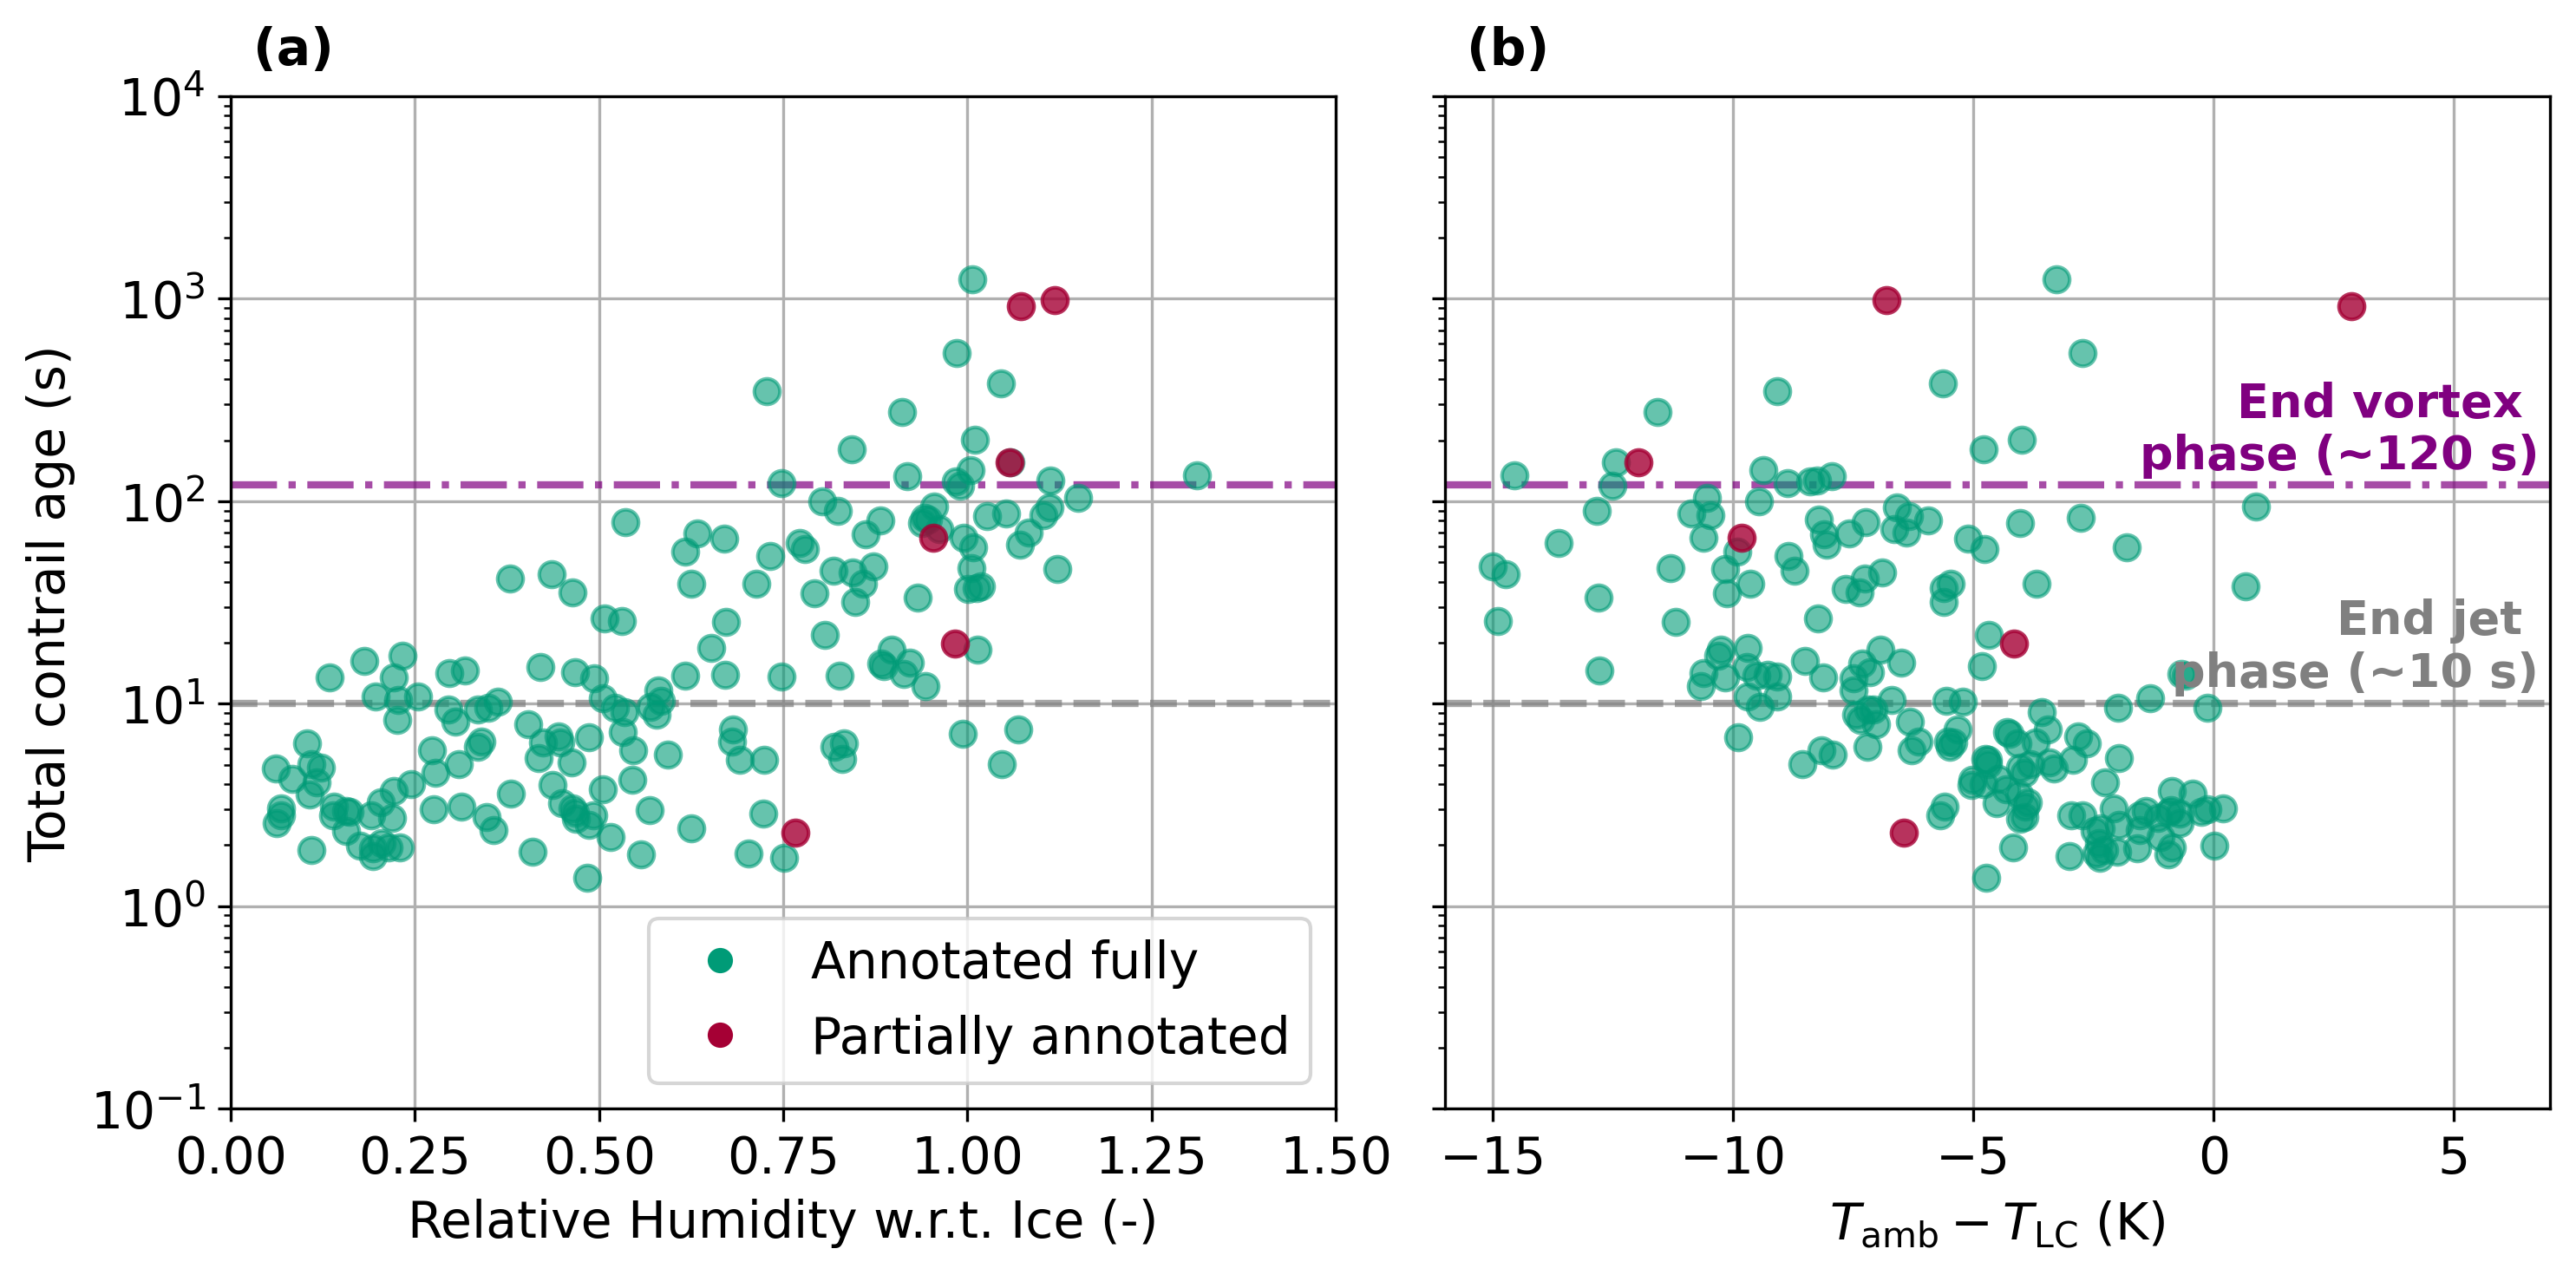

In [11]:
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})

# Masks to plot out_of_frame on top
mask_full = out_of_frame == 0
mask_partial = out_of_frame == 1


cmap = mcolors.ListedColormap(["#009b77", "#a50034"])
norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 5), sharey=True, dpi=300
)

# --- Scatter plots ---
ax1.scatter(
    rhi_era5_vals[mask_full],
    total_age_vals[mask_full],
    color="#009b77",
    alpha=0.6,
    s=50,
    zorder=3,
    clip_on=False,
    label="Annotated fully"
)

# Then: partially annotated (on top)
ax1.scatter(
    rhi_era5_vals[mask_partial],
    total_age_vals[mask_partial],
    color="#a50034",
    alpha=0.8,
    s=50,
    zorder=6,  # higher zorder = on top
    clip_on=False,
    label="Partially annotated"
)
ax1.set_xlabel("Relative Humidity w.r.t. Ice (-)")
ax1.set_ylabel("Total contrail age (s)")
ax1.set_yscale("log")
ax1.set_xlim(0, 1.50)
ax1.set_ylim(0.1, 10000)
ax1.grid(True)

ax2.scatter(
    dtlc_vals[mask_full],
    total_age_vals[mask_full],
    color="#009b77",
    alpha=0.6,
    s=50,
    zorder=3,
    clip_on=False
)

ax2.scatter(
    dtlc_vals[mask_partial],
    total_age_vals[mask_partial],
    color="#a50034",
    alpha=0.8,
    s=50,
    zorder=6,
    clip_on=False
)
ax2.set_xlabel(r"$T_{\mathrm{amb}} - T_{\mathrm{LC}}$ (K)")
ax2.set_yscale("log")
ax2.grid(True)
ax2.set_xlim(-16, 7)

# --- Reference lines (no legend) ---
for ax in (ax1, ax2):
    ax.axhline(10, linestyle="--", color="grey", alpha=0.7, linewidth=2)
    ax.axhline(120, linestyle="-.", color="purple", alpha=0.7, linewidth=2)

# Annotations
ax2.text(
    0.99, 11,
    "End jet \nphase (~10 s)",
    color="grey",
    fontsize=13,
    ha="right",
    va="bottom",
    fontweight="bold",
    transform=ax2.get_yaxis_transform()
)

ax2.text(
    0.99, 130,
    "End vortex \nphase (~120 s)",
    color="purple",
    fontsize=13,
    ha="right",
    va="bottom",
    fontweight="bold",
    transform=ax2.get_yaxis_transform()
)

# --- Color legend ---
color_legend = [
    Line2D([0], [0], marker='o', color='white',
           markerfacecolor="#009b77", markersize=8,
           label="Annotated fully"),
    Line2D([0], [0], marker='o', color='white',
           markerfacecolor="#a50034", markersize=8,
           label="Partially annotated")
]

ax1.legend(handles=color_legend, loc="lower right")

# --- Panel labels ---
ax1.text(
    0.02, 1.07, "(a)",
    transform=ax1.transAxes,
    fontsize=14,
    fontweight="bold",
    va="top",
    ha="left"
)

ax2.text(
    0.02, 1.07, "(b)",
    transform=ax2.transAxes,
    fontsize=14,
    fontweight="bold",
    va="top",
    ha="left"
)

fig.tight_layout()
plt.savefig("figures/fig07.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Statistics on contrail lifetimes

In [ ]:
print(f"Pecentage of flights surviving above 10(s): {round(sum([1 for age in total_age_vals if age >= 10]) / len(total_age_vals), 3)}% ({sum([1 for age in total_age_vals if age >= 10])} cases)")
print(f"Pecentage of flights surviving above 120(s): {round(sum([1 for age in total_age_vals if age >= 120]) / len(total_age_vals), 3)}% ({sum([1 for age in total_age_vals if age >= 120])} cases)")

Pecentage of flights surviving above 10(s): 0.482% (94 cases)
Pecentage of flights surviving above 120(s): 0.087% (17 cases)


In [ ]:
# ensure arrays are 1D
age = np.array(total_age_vals).ravel()
rhi = np.array(rhi_era5_vals).ravel()

# valid data (remove NaNs)
mask = (~np.isnan(age)) & (~np.isnan(rhi))
age = age[mask]
rhi = rhi[mask]

def stats_for_range(min_age, max_age):
    if max_age is None:
        sel = age > min_age
    else:
        sel = (age >= min_age) & (age < max_age)

    mean_rhi = rhi[sel].mean()
    std_rhi = rhi[sel].std(ddof=1)  # sample standard deviation
    count = sel.sum()

    return mean_rhi, std_rhi, count

ranges = [
    ("0-10 s", 0, 10),
    ("10-120 s", 10, 120),
    (">120 s", 120, None)
]

for label, mn, mx in ranges:
    mean_rhi, std_rhi, count = stats_for_range(mn, mx)
    print(f"{label}: n={count}, mean RHi={mean_rhi:.3f}, std RHi={std_rhi:.3f}")

0-10 s: n=101, mean RHi=0.395, std RHi=0.235
10-120 s: n=77, mean RHi=0.741, std RHi=0.271
>120 s: n=17, mean RHi=0.995, std RHi=0.140


In [ ]:
# Clean NaNs
mask = (~np.isnan(rhi_vals)) & (~np.isnan(total_age_vals)) & (total_age_vals > 0)
x = rhi_vals[mask].reshape(-1, 1)
y = total_age_vals[mask]

# Fit linear regression
model = LinearRegression().fit(x, y)
r2 = model.score(x, y)

print(f"R² (rhi vs age): {r2:.4f}")

# log(age)
y_log = np.log(y)
model_log = LinearRegression().fit(x, y_log)
r2_log = model_log.score(x, y_log)

print(f"R² (rhi vs log(age)): {r2_log:.4f}")


R² (rhi vs age): 0.1351
R² (rhi vs log(age)): 0.4874


In [ ]:
# Clean NaNs
mask = (~np.isnan(rhi_era5_vals)) & (~np.isnan(total_age_vals)) & (total_age_vals > 0)
x = rhi_era5_vals[mask].reshape(-1, 1)
y = total_age_vals[mask]

# Fit linear regression
model = LinearRegression().fit(x, y)
r2 = model.score(x, y)

print(f"R² (rhi era5 vs age): {r2:.4f}")

# log(age)
y_log = np.log(y)
model_log = LinearRegression().fit(x, y_log)
r2_log = model_log.score(x, y_log)

print(f"R² (rhi era5 vs log(age)): {r2_log:.4f}")

R² (rhi era5 vs age): 0.1499
R² (rhi era5 vs log(age)): 0.5124


In [ ]:
dtlc_vals = dtlc_vals.reshape(-1,)
dtlc = dtlc_vals.flatten()
# Clean NaNs
mask = (~np.isnan(dtlc_vals)) & (~np.isnan(total_age_vals)) & (total_age_vals > 0)
x = dtlc_vals[mask].reshape(-1, 1)
y = total_age_vals[mask]

# Fit linear regression
model = LinearRegression().fit(x, y)
r2 = model.score(x, y)

print(f"R² (dtlc vs age): {r2:.4f}")

# log(age)
y_log = np.log(y)
model_log = LinearRegression().fit(x, y_log)
r2_log = model_log.score(x, y_log)

print(f"R² (dtlc vs log(age)): {r2_log:.4f}")

R² (dtlc vs age): 0.0003
R² (dtlc vs log(age)): 0.2327
